# Exploring some ecological datasets

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import os
from urllib.request import urlopen
import json
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.interpolate import griddata
import pyepsg

# Overview

## IUCN API

The IUCN API documentation is here: https://apiv3.iucnredlist.org/api/v3/docs

All API calls will start with most of that as a stem. We will change the endpoints to access different types of information, sometimes requiring us to include additional parameters.

For most endpoints we will also need an authorization token.

Try one of the examples, and note how the URL is filled in with different parameters and token=XXXXX. We'll borrow that token for our work today, but if you do real work with this API, request your own token. You can then store the value of this token using the `os` package:

`os.environ['IUCN_TOKEN'] = XXXXX`

 and retrieve it with the same package:
 
`iucn_token = os.getenv('IUCN_TOKEN')`

In [2]:
# Temporary token, derived from IUCN example website
iucn_token="9bb4facb6d23f48efbf424bb05c0c1ef1cf6f468393bc745d42179ac4aca5fee"

# Root URL for IUCN
iucn_url="https://apiv3.iucnredlist.org"

# URL for API endpoint
spp_page_url = iucn_url+'/api/v3/species/page/2?token='+iucn_token

There are multiple ways to read in JSON data in Python. The `urlopen` functionality is quite easy to use, since it accepts a URL directly. This can then be combined with `json.loads` to convert this into a data array (similarly to `jsonlite::fromJSON` in R):

In [3]:
# Read in JSON from URL 
spp_page = urlopen(spp_page_url)

data_json = json.loads(spp_page.read())

The above generates a long list of output; the data of interest are stored in a dictionary format, with a column name `result`. We can also use Pandas to convert this into a data frame:

In [4]:
# Convert dictionary output of "result" field to a Pandas dataframe
spp_page_df = pd.DataFrame.from_dict(data_json['result'])

# Display dataframe
spp_page_df

,taxonid,kingdom_name,phylum_name,class_name,order_name,family_name,genus_name,scientific_name,taxonomic_authority,infra_rank,infra_name,population,category,main_common_name
0,43280,PLANTAE,TRACHEOPHYTA,LILIOPSIDA,POALES,BROMELIACEAE,Pitcairnia,Pitcairnia aequatorialis,L.B.Sm.,None,None,None,EN,None
1,43281,PLANTAE,TRACHEOPHYTA,LILIOPSIDA,POALES,BROMELIACEAE,Pitcairnia,Pitcairnia alata,L.B.Sm.,None,None,None,EN,None
2,43282,PLANTAE,TRACHEOPHYTA,LILIOPSIDA,POALES,BROMELIACEAE,Pitcairnia,Pitcairnia andreetae,H.Luther,None,None,None,VU,None
3,43283,PLANTAE,TRACHEOPHYTA,LILIOPSIDA,POALES,BROMELIACEAE,Pitcairnia,Pitcairnia bergii,H.Luther,None,None,None,EN,None
4,43284,PLANTAE,TRACHEOPHYTA,LILIOPSIDA,POALES,BROMELIACEAE,Pitcairnia,Pitcairnia caduciflora,Rauh &amp; E.Gross,None,None,None,EN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,61381,ANIMALIA,CHORDATA,ACTINOPTERYGII,CYPRINIFORMES,LEUCISCIDAE,Squalius,Squalius illyricus,"Heckel &amp; Kner, 1858",None,None,None,NT,Illyrian chub
9996,61382,ANIMALIA,CHORDATA,ACTINOPTERYGII,CYPRINIFORMES,CYPRINIDAE,Luciobarbus,Luciobarbus labiosa,"(Pellegrin, 1920)",None,None,None,LC,Sebou Barbel
9997,61383,ANIMALIA,CHORDATA,ACTINOPTERYGII,CYPRINIFORMES,NEMACHEILIDAE,Nemacheilus,Nemacheilus sp. nov.,None,None,None,None,EN,None
9998,61384,ANIMALIA,CHORDATA,ACTINOPTERYGII,CYPRINIFORMES,LEUCISCIDAE,Ladigesocypris,Ladigesocypris mermere,"(Ladiges, 1960)",None,None,None,DD,None


### Access specific info on a single species

Humpback whale is ID \# 13006. Let's find the countries where it can be found! (or try a different taxon ID from the previous step)

In [5]:
# URL for API endpoint: humpback whales
spp_country_url = iucn_url + '/api/v3/species/countries/id/' + '13006'+ '?token=' + iucn_token

# Read in JSON from URL
spp_ctry = urlopen(spp_country_url)
data_json = json.loads(spp_ctry.read())

# Convert dictionary output to Pandas dataframe
spp_ctry_df = pd.DataFrame.from_dict(data_json['result'])

In [6]:
spp_ctry_df

,code,country,presence,origin,distribution_code
0,AE,United Arab Emirates,Extant,Native,Native
1,AG,Antigua and Barbuda,Extant,Native,Native
2,AI,Anguilla,Extant,Native,Native
3,AO,Angola,Extant,Native,Native
4,AQ,Antarctica,Extant,Native,Native
...,...,...,...,...,...
160,WF,Wallis and Futuna,Extant,Native,Native
161,WS,Samoa,Extant,Native,Native
162,YE,Yemen,Extant,Native,Native
163,YT,Mayotte,Extant,Native,Native


## WoRMS API

Now let's try it with the World Register of Marine Species! https://www.marinespecies.org/rest

### Access AphiaID for a genus name

Let's find the ID for genus Balaenoptera, a group that includes the biggest whales in the oceans.

In [7]:
# Root URL for WoRMS 
worms_url = "https://www.marinespecies.org/rest/"

# Endpoint URL
worms_id_url = worms_url + 'AphiaIDByName/' + 'balaenoptera'

# Read in JSON from URL
worms_data = urlopen(worms_id_url)
worms_id = json.loads(worms_data.read())

### Access children of a genus

The ID for Balaenoptera is 137013, but it is stored in a variable already. Let's find the "children", i.e., the members of the next classification down (genus -\> species)

In [8]:
# Endpoint URL for children
worms_child_url = worms_url + 'AphiaChildrenByAphiaID/' + str(worms_id)

# Read in JSON from URL
worms_data = urlopen(worms_child_url)
worms_child = json.loads(worms_data.read())

In [9]:
# Convert to Pandas dataframe
worms_datatable = pd.DataFrame(worms_child)

# Filter out non-accepted data
worms_accepted = worms_datatable[worms_datatable['status'] == 'accepted']

### Access classification of a species

Not all returned data are equally easy to work with - here's a list of lists of lists.

In [10]:
# Endpoint URL
worms_class_url = worms_url + 'AphiaClassificationByAphiaID/' + str(worms_id)

# Read in JSON
worms_data = urlopen(worms_child_url)
worms_class = json.loads(worms_data.read())

## Read in data

### read in cleaned IUCN data

This set of species includes all marine-associated mammals only.  For now, note IUCN species ID, scientific and common name, and risk category, among other information.  The risk category is what we want - up to date as of the end of 2021.

In [11]:
# Read in marine mammal data into Pandas dataframe
iucn_spp_df = pd.read_csv('data/iucn_mar_mammal_info_v2021-3.csv')

### Read in cleaned AquaMaps species info

This set of species includes all marine mammals only.  For now, note AquaMaps species ID, IUCN species ID, name, sciname, and risk category, among other information.  Here, the risk category is not up to date - this dataset was last updated in 2020.

The critical piece here is the AquaMaps species ID, which we need to know for the spatial information in a moment.  We'll use IUCN id to join the up-to-date risk category to the AquaMaps species ID.


In [12]:
am_spp_df = pd.read_csv('data/am_mammal_info_v10_2019.csv')

### Read in cleaned AquaMaps species-cell info

Note the columns loiczid, AquaMaps species id, and probability of occurrence.  LOICZID is a cell code that we'll match to spatial information in a minute.

In [13]:
am_spp_cells_df = pd.read_csv('data/am_mammal_hcaf_cropped_v10_2019.csv')

### Read in cleaned HCAF data

This is cropped to the Eastern Pacific Ocean - east of -150 longitude, north of the equator.  We will turn this into a raster for mapping our species!

In [14]:
# Read in full dataset
am_hcaf_df = pd.read_csv('data/am_hcaf_cropped_v7.csv')

# Display all column names
am_hcaf_df.columns

Index(['ID', 'CsquareCode', 'LOICZID', 'NLimit', 'Slimit', 'WLimit', 'ELimit',
       'CenterLat', 'CenterLong', 'CellArea', 'OceanArea', 'PWater',
       'ClimZoneCode', 'FAOAreaM', 'FAOAreaIn', 'CountryMain', 'CountrySecond',
       'CountryThird', 'CountrySubMain', 'CountrySubSecond', 'CountrySubThird',
       'EEZ', 'LME', 'LMEBorder', 'MEOW', 'OceanBasin', 'IslandsNo',
       'Area0_20', 'Area20_40', 'Area40_60', 'Area60_80', 'Area80_100',
       'AreaBelow100', 'ElevationMin', 'ElevationMax', 'ElevationMean',
       'ElevationSD', 'DepthMin', 'DepthMax', 'DepthMean', 'DepthSD',
       'SSTAnMean', 'SBTAnMean', 'SalinityMean', 'SalinityBMean',
       'PrimProdMean', 'IceConAnn', 'OxyMean', 'OxyBMean', 'LandDist', 'Shelf',
       'Slope', 'Abyssal', 'TidalRange', 'Coral', 'Estuary', 'Seamount',
       'MPA'],
      dtype='object')

In [15]:
# Select data where ocean_area is greater than zero, extract columns of interest
longlat_id_df = am_hcaf_df[am_hcaf_df['OceanArea'] > 0][['LOICZID','CenterLong','CenterLat']]

longlat_id_df

,LOICZID,CenterLong,CenterLat
0,129040,-100.25,0.25
1,129039,-100.75,0.25
2,128320,-100.25,0.75
3,128319,-100.75,0.75
4,129038,-101.25,0.25
...,...,...,...
12932,41104,-148.25,61.25
12936,41102,-149.25,61.25
12937,41101,-149.75,61.25
12938,40382,-149.25,61.75


In [21]:
x = longlat_id_df['CenterLong']
y = longlat_id_df['CenterLat']
z = longlat_id_df.LOICZID


xi = np.arange(np.min(x),np.max(x),0.5)
yi = np.arange(np.min(y),np.max(y),0.5)
xi,yi = np.meshgrid(xi,yi)
zi = griddata((x,y),z,(xi,yi),method='linear')

<ipython-input-23-c3b126a716e6>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cf=ax.pcolor(xi,yi,zi)


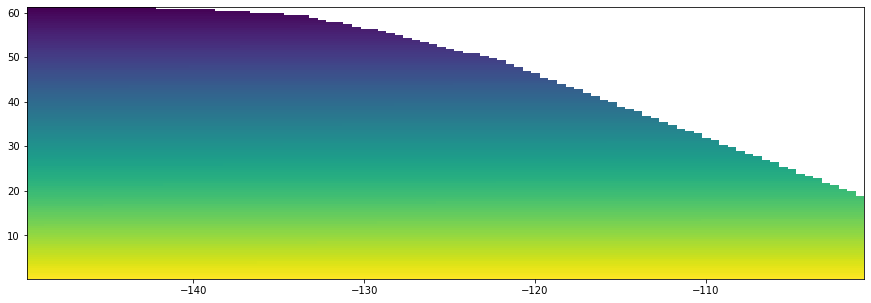

In [23]:
fig = plt.figure(figsize=(15, 5))
ax = plt.axes()
#ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_extent([-180,180,-90,90])   # change region of interest if desired
#ax.coastlines()  # add coastlines

# Add  data
cf=ax.pcolor(xi,yi,zi)
#fig.colorbar(cf,ax=ax)

In [ ]:
zi